# Computer Vision

## Lab 6

### Imports

In [204]:
# IO
from glob import glob

# Computation
import cv2
import numpy as np
from scipy import spatial
from skimage import color, img_as_float32
from natsort import natsorted

# Plotting
import matplotlib.pyplot as plt

### Load images

In [205]:
path_pairs = list(zip(
    natsorted(glob('../assets/images-1024x768/*.png')),
    natsorted(glob('../assets/masks-1024x768/*.png')),
))

images = np.array([img_as_float32(cv2.cvtColor(cv2.imread(i_path), cv2.COLOR_BGR2RGB)) for i_path, _ in path_pairs])

masks = np.array([img_as_float32(cv2.cvtColor(cv2.imread(m_path), cv2.COLOR_BGR2RGB)) for _, m_path in path_pairs])
masks_gray = [color.rgb2gray(mask) for mask in masks]
masks_bin = [cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1] for mask in masks_gray]

num_images, height, width, channels = images.shape


### 1. Find Contours

#### 1.1. get_puzzle_contour

In [206]:
def get_puzzle_contour(mask):
    contours, _ = cv2.findContours(mask, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    max_contour = np.array([])
    max_contour_area = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        
        is_closed = area > cv2.arcLength(contour, closed=True)
        has_max_area = area > max_contour_area
        
        if is_closed and has_max_area:
            max_contour = contour.reshape(-1, contour.shape[-1])
            max_contour_area = area
            
    return max_contour

#### 1.2. get_clockwise_contour

In [207]:
def get_clockwise_contour(contour):
    if (cv2.contourArea(contour, oriented=True) < 0):
        return np.flip(contour, axis=0)
    return contour

#### 1.3 Function explanations

*cv2.findContours* : Explanation

*cv2.contourArea with oriented=True* : Explanation

#### 1.4 Plotting contours

In [208]:
contours = [get_clockwise_contour(get_puzzle_contour(np.array(mask*255, dtype=np.uint8))) for mask in masks_bin]

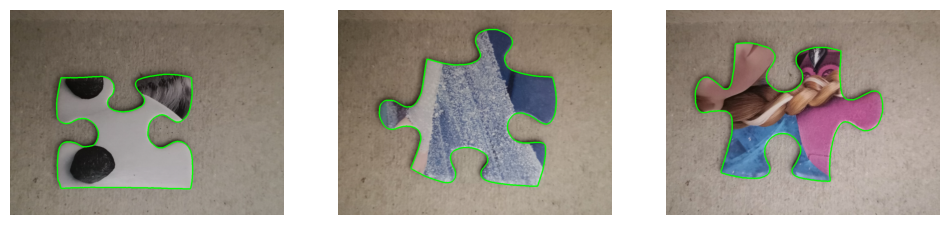

In [209]:
num_sample = 3
drawn_images = np.random.choice(len(masks), num_sample)

fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    image = np.copy(images[idx])
    contour = contours[idx]
    contour_image = cv2.drawContours(image, [contour.reshape(-1, 1, 2)], 0, (0,1,0), 3)
    
    fig.add_subplot(1, num_sample, i+1)
    plt.imshow(contour_image)
    plt.axis('off')

### 2. Shape Models

#### 2.1. Extract Sides

##### 2.1.1 Load Corners from json file

In [210]:
import json
with open("../assets/corners.json", "r") as file:
    names, corner_ratios = json.load(file)
    
corners = corner_ratios * np.array([width, height])

##### 2.1.2 extract_sides

In [233]:
def extract_sides(contour, corners):
    corner_indices = spatial.KDTree(contour).query(corners)[1]
    corner_coords = contour[corner_indices]
    
    # Sort coordinates according to contour
    sorted_corner_indices = np.sort(corner_indices)
    sorted_corner_coords = np.zeros_like(corner_coords)
    for i, new_i in enumerate(np.argsort(corner_indices)):
        sorted_corner_coords[new_i] = corner_coords[i]
    
    # Roll first corner to be at 0
    contour = np.roll(contour, -sorted_corner_indices[0], axis=0)
    shifted_corner_indices = sorted_corner_indices - sorted_corner_indices[0]
    
    # Split contour to sides
    side_contours = np.split(contour, shifted_corner_indices)
    
    # Join first and last items
    if len(side_contours) == 5:
        last = side_contours[-1]
        side_contours = side_contours[:-1]
        side_contours[0] = np.concatenate((last, side_contours[0]))
    
    # Append corner to end (side starts and ends with corner)
    for i in range(len(side_contours)):
        side_contours[i] = np.append(side_contours[i], [side_contours[(i+1)%4][0]], axis=0)
    
    return side_contours


##### 2.1.3 Draw sides

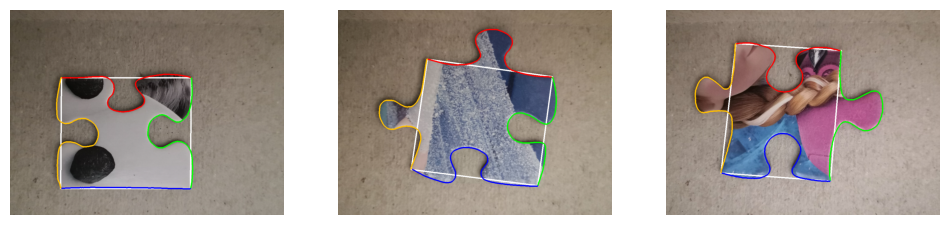

In [237]:
def draw_corners(image, corners):
    image = cv2.circle(image, corners[0], radius=0, color=(1,0,0), thickness=20)
    image = cv2.circle(image, corners[1], radius=0, color=(0,1,0), thickness=20)
    image = cv2.circle(image, corners[2], radius=0, color=(0,0,1), thickness=20)
    image = cv2.circle(image, corners[3], radius=0, color=(1,0.75,0), thickness=20)
    
    return image

fig = plt.figure(figsize=(num_sample*4, 4))

for i, idx in enumerate(drawn_images):
    image = np.copy(images[idx])
    image_corners = corners[idx]
    
    side_contours = extract_sides(contours[idx], image_corners)
    
    rounded_corners = image_corners.astype(int)
    
    image = cv2.polylines(image, [rounded_corners], 1, (1,1,1), 3)
    
    image = cv2.polylines(image, [side_contours[0]], 0, (1,0,0), 3)
    image = cv2.polylines(image, [side_contours[1]], 0, (0,1,0), 3)
    image = cv2.polylines(image, [side_contours[2]], 0, (0,0,1), 3)
    image = cv2.polylines(image, [side_contours[3]], 0, (1,0.75,0), 3)
    
    fig.add_subplot(1, num_sample, i+1)
    plt.imshow(image)
    plt.axis('off')